# Movie recommendation on Amazon SageMaker with Factorization Machines

### Background

In many ways, recommender systems were a catalyst for the current popularity of machine learning.  One of Amazon's earliest successes was the "Customers who bought this, also bought..." feature, while the million dollar Netflix Prize spurred research, raised public awareness, and inspired numerous other data science competitions.

Recommender systems can utilize a multitude of data sources and ML algorithms, and most combine various unsupervised, supervised, and reinforcement learning techniques into a holistic framework.  However, the core component is almost always a model which which predicts a user's rating (or purchase) for a certain item based on that user's historical ratings of similar items as well as the behavior of other similar users.

Factorization Machines have shown themselves to be very effective at this task, and Amazon SageMaker includes an almost perfectly scalable implementation of a distributed Factorization Machine algorithm.  Today we'll use that to build a recommender system.  We'll start by bringing in and preparing our dataset, and then discuss the algorithm and training process, and finish by deploying to a real-time endpoint for generating predictions.

### Imports

Let's start by importing our necessary modules here, to get it out of the way.  Also, update the s3 bucket, prefix, or IAM role as needed.

In [1]:
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer

import boto3, csv, io, json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Defaults

We will set a project name used to group Amazon SageMaker and Amazon S3 resources related to this specific notebook

In [2]:
project_name = 'sagemaker-workshop-movie-recommender'
train_instance_count = 1
train_instance_type = "ml.c5.18xlarge"
train_dataset_uri = 'http://files.grouplens.org/datasets/movielens/ml-latest.zip' 

### Helper Function: Identify SageMaker IAM service role

SageMaker resources will need access to several resources to complete training jobs

In [3]:
def get_sagemaker_role():
    try:
        # if running within Amazon SageMaker Notebook Instance, get current execution role
        role = get_execution_role()
    except:
        # otherwise, guess the role
        result = %sx aws iam list-roles | grep -e 'role/service-role' | grep -i 'sagemaker' | tr -d ' '
        role = result[0][7:-2]
        print("Found potential SageMaker service role: {}".format(role))
    return role

In [4]:
role = get_sagemaker_role()

Found potential SageMaker service role: arn:aws:iam::306280812807:role/service-role/AmazonSageMaker-ExecutionRole-20180117T091311


### Helper Function: Identify SageMaker Container for specified region

Set boto3 clients to use a valid SageMaker region and to select the proper container to use for training and endpoint deployment based on the specific algorithm to be used

In [5]:
available_regions=['us-east-1','us-east-2','us-west-2','eu-west-1'] # available Amazon SageMaker regions
region_name = boto3.Session().region_name
if region_name not in available_regions:
    region_name=available_regions[0]
print('Setting SageMaker region to: {}'.format(region_name))
default_bucket = '{}-{}'.format(project_name, region_name)
print('Setting default S3 bucket to: {}'.format(default_bucket))

Setting SageMaker region to: us-east-1
Setting default S3 bucket to: sagemaker-workshop-movie-recommender-us-east-1


## Helper Function: Protocol Buffer formatting

In [6]:
prefix = 'protobuf_6'
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test')

def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)

In [7]:
### TODO: If not exists, create S3 bucket
s3 = boto3.client("s3", region_name=region_name)
## check if bucket exists
## if not...
s3.create_bucket(Bucket=default_bucket)

{'Location': '/sagemaker-workshop-movie-recommender-us-east-1',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Sun, 06 May 2018 03:43:37 GMT',
   'location': '/sagemaker-workshop-movie-recommender-us-east-1',
   'server': 'AmazonS3',
   'x-amz-id-2': 'zH4tuxoyWfCuE1z6QJybmK3uRzigMmh5B23V4b6jOIlJmrY0s74coAv3evkFAmb9iFsO9BBj8eE=',
   'x-amz-request-id': '0CF4F504BACA326D'},
  'HTTPStatusCode': 200,
  'HostId': 'zH4tuxoyWfCuE1z6QJybmK3uRzigMmh5B23V4b6jOIlJmrY0s74coAv3evkFAmb9iFsO9BBj8eE=',
  'RequestId': '0CF4F504BACA326D',
  'RetryAttempts': 0}}

### Download and look at our data
Let's get our data. Factorization Machines work well as recommendation solutions, such as movie recommendations! Also, FM's do great on lots of data, so let's get something heavy. Maybe the MovieLens dataset, with 20 million ratings?

In [8]:
!rm -f /tmp/dataset.zip
!wget -O /tmp/dataset.zip $train_dataset_uri
!unzip -j -o /tmp/dataset.zip -d /tmp/dataset

--2018-05-06 03:43:38--  http://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248434223 (237M) [application/zip]
Saving to: ‘/tmp/dataset.zip’

/tmp/dataset.zip    100%[===================>] 236.92M  55.6MB/s    in 4.4s    

2018-05-06 03:43:43 (53.7 MB/s) - ‘/tmp/dataset.zip’ saved [248434223/248434223]

Archive:  /tmp/dataset.zip
  inflating: /tmp/dataset/genome-scores.csv  
  inflating: /tmp/dataset/genome-tags.csv  
  inflating: /tmp/dataset/links.csv  
  inflating: /tmp/dataset/movies.csv  
  inflating: /tmp/dataset/ratings.csv  
  inflating: /tmp/dataset/README.txt  
  inflating: /tmp/dataset/tags.csv   


Let's take a look at the top of this file, shall we? This should show us the range of user ids, which we will need later.

In [9]:
%cd /tmp/dataset
!head -5000000 ratings.csv > ratings.trunc.csv
!mv ratings.trunc.csv ratings.csv
!head -10 ratings.csv
!tail -10 ratings.csv


/tmp/dataset
userId,movieId,rating,timestamp
1,110,1.0,1425941529
1,147,4.5,1425942435
1,858,5.0,1425941523
1,1221,5.0,1425941546
1,1246,5.0,1425941556
1,1968,4.0,1425942148
1,2762,4.5,1425941300
1,2918,5.0,1425941593
1,2959,4.0,1425941601
51433,172,5.0,1394863719
51433,173,5.0,1394863483
51433,208,5.0,1394863612
51433,333,5.0,1394863271
51433,442,5.0,1394863961
51433,541,5.0,1394863673
51433,661,5.0,1394863273
51433,783,4.0,1394863276
51433,1035,0.5,1394863180
51433,1320,5.0,1394863183


In [10]:
data = pd.read_csv("/tmp/dataset/ratings.csv", sep=',')
data.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


Users: 51433

Users Most Rating: 
45811    18276
8659      9279
24025     4946
41190     4785
33940     4120
32984     3958
40207     3896
30494     3796
37222     3722
39742     3614
Name: userId, dtype: int64
Movies Rated: 34718

Movies Most Rated: 
356     17572
318     17520
296     16690
593     16086
2571    14896
Name: movieId, dtype: int64


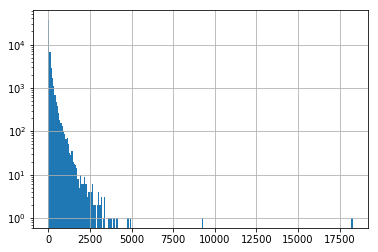

In [28]:
user_ratings = data['userId'].value_counts()
user_count = user_ratings.count()
print("Users: {}\n".format(user_count))
print("Users Most Rating: \n{}".format(user_ratings.head(n=10)))
ax = user_ratings.hist(bins=250)
ax.set_yscale('log')
plt.show()

Movies Rated: 34718

Movies Most Rated: 
356     17572
318     17520
296     16690
593     16086
2571    14896
260     14767
480     14294
527     13001
110     12683
1       12594
Name: movieId, dtype: int64


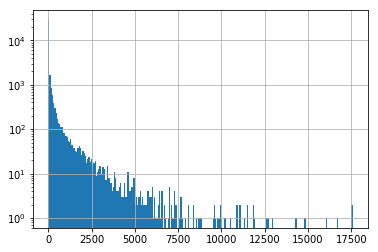

In [30]:
movie_ratings = data['movieId'].value_counts()
movie_count = movie_ratings.count()
print("Movies Rated: {}\n".format(movie_count))
print("Movies Most Rated: \n{}".format(movie_ratings.head(n=10)))
ax = movie_ratings.hist(bins=250)
ax.set_yscale('log')
plt.show()

### Prepare our data

We remove the header, then shuffle the data before splitting it into training and prediction segments.

In [31]:
!tail -n +2 ratings.csv | shuf -o ratings.shuffled

result=!wc -l ratings.shuffled | cut -d' ' -f1
lines_total=result[0]
lines_split=int(int(lines_total)/10)
!split --lines $lines_split ratings.shuffled

!cat xa{a..h} > ratings.shuffled.training
!cat xai > ratings.shuffled.validation
!cat xaj > ratings.shuffled.prediction

result=!wc -l ratings.shuffled.training | cut -d' ' -f1
lines_training=int(result[0])
print("Training set: {}".format(lines_training))
!head -n5 ratings.shuffled.training

result=!wc -l ratings.shuffled.validation | cut -d' ' -f1      
lines_validation=int(result[0])
print("Validation set: {}".format(lines_validation))  
!head -n5 ratings.shuffled.validation
      
result=!wc -l ratings.shuffled.prediction | cut -d' ' -f1
lines_prediction=int(result[0])
print("Prediction set: {}".format(lines_prediction))
!head -n5 ratings.shuffled.prediction


Training set: 3999992
19989,3362,3.0,992703416
2901,4992,3.0,1139725416
29787,4973,5.0,1293711311
23235,1479,3.0,1079858091
2447,1265,5.0,1037473386
Validation set: 499999
44209,5959,3.5,1072763553
45608,1270,2.0,965059815
35508,502,0.5,1399133355
9841,1203,4.5,1388445978
38971,1214,5.0,1418952843
Prediction set: 499999
18079,2273,3.0,1496207366
42702,80489,4.5,1348004072
42198,3285,2.0,952718187
21601,1573,1.0,1483031450
26898,912,5.0,1429956149


### Build training set and test set

When using Factorization Machines for building a recommender system, the algorithm expects the data to look something like:

|Rating|User1|User2|...|UserN|Movie1|Movie2|Movie3|...|MovieM|
|---|---|---|---|---|---|---|---|---|---|
|4|1|0|...|0|1|0|0|...|0|
|5|1|0|...|0|0|1|0|...|0|
|3|0|1|...|0|1|0|0|...|0|
|4|0|1|...|0|0|0|1|...|0|

- Our target column is the rating for that user movie combination.  This could be the number of stars given, or could be a binarized version (movies with ratings 4 and above are set to `1`, otherwise `0`).  
- We have a set of `N` features which are a one-hot encoding of user.  They only take a value of `1` to indicate observations which belong to that customer.
- We also have a set of `M` features which are a one-hot encoding of movie.

Sagemaker's Factorization Machines can handle sparse data, meaning we only store the non-zero entries, but to contruct the sparse feature matrices we need to figure out the size of the training and testing sets. We also normalized the movie ids here.

In [32]:
normalizedMovieIdDict = {}
normalizedIdMovies = 0

with open('ratings.shuffled','r') as f:
    samples = csv.reader(f,delimiter=',')
    for userId,movieId,rating,timestamp in samples:
        if movieId not in normalizedMovieIdDict:
            normalizedMovieIdDict[movieId] = normalizedIdMovies
            normalizedIdMovies = normalizedIdMovies + 1


nbUsers = user_count
nbMovies = normalizedIdMovies
nbFeatures = nbUsers+nbMovies

Now, we can read our training and test datsets in.

In [33]:
def loadDataset(filename, total_lines, columns):
    # Features are one-hot encoded in a sparse matrix
    
    X = lil_matrix((total_lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line = 0
    with open(filename,'r') as f:
        samples=csv.reader(f,delimiter=',')
        for userId,movieId,rating,timestamp in samples:
            X[line,int(userId)-1] = 1
            normalizedMovieId = normalizedMovieIdDict[movieId]
            X[line,int(nbUsers)+int(normalizedMovieId)-1] = 1
            if float(rating) >= 4:
                Y.append(1)
            else:
                Y.append(0)
            line = line+1
            
    Y = np.array(Y).astype('float32') 
    return X,Y

In [34]:
%%time

X_train, Y_train = loadDataset('ratings.shuffled.training', lines_training, nbFeatures)
X_test, Y_test = loadDataset('ratings.shuffled.validation', lines_validation, nbFeatures)

CPU times: user 1min 27s, sys: 836 ms, total: 1min 28s
Wall time: 1min 28s


### Convert to protobuf and save to S3
We train our models from data in S3; writing a helper function here to help us with that.

In [ ]:
%%time

train_data_location = writeDatasetToProtobuf(X_train, Y_train, default_bucket, train_prefix, train_key)    
test_data_location  = writeDatasetToProtobuf(X_test, Y_test, default_bucket, test_prefix, test_key)

train_data_location = "s3://{}/{}/train/{}".format(default_bucket, prefix, train_key)  
test_data_location  = "s3://{}/{}/test/{}".format(default_bucket, prefix, test_key)
  
print(train_data_location)
print(test_data_location)

### Run Factorization Machine training job with validation
Sagemaker algorithms are stored as Docker containers in ECS, and we need the URI of the containers. This will be region specific.

In [ ]:
fm_containers = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/factorization-machines:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/factorization-machines:latest',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com/factorization-machines:latest'}

training_image = fm_containers[region_name]

Training time! Some things to note here that might not be obvious:
<ul>
    <li>You can specify the hardware you want to use; Sagemaker will create your cluster and deploy your image</li>
    <li>You can optionally proviode a test dataset as well, which we have done here</li>
    <li>The metrics will be printed out after each epoch and mini batch</li>
</ul>

In order to train our Factorization Machine, we'll need to specify some hyperparameters.  First, let's think about what a Factorization Machine does:  

$$\hat{r} = w_0 + \sum_{i} {w_i x_i} + \sum_{i} {\sum_{j > i} {\langle v_i, v_j \rangle x_i x_j}}$$

where $\hat{r}$ is the movie rating, $x_i$ are the one-hot encoded user and movie indicators, $w_i$ are linear weights, and the second term represents the pairwise feature interactions as a reduced dimension factorization.  This reduction in dimensionality allows us to find a smaller, more generalizable representation of information in the large sparse input dataset.  Key hyperparameters are therefore:

- `feature_dim`: How big our initial movie 
- `num_factors`: How large our reduced dimensionality representation of interactions should be

We also specify hyperparameters like `mini_batch_size` and `epochs` which can be tuned for improved performance.

Hit "play" and sit back to let Sagemaker do all the work here

In [ ]:
%%time

fm_trained_model_location  = 's3://{}/{}/{}/output'.format(default_bucket, prefix, "fm")

fm = sagemaker.estimator.Estimator(
    training_image,
    role, 
    train_instance_count=train_instance_count, 
    train_instance_type=train_instance_type,
    output_path=fm_trained_model_location,
    sagemaker_session=sagemaker.Session())

fm.set_hyperparameters(
    feature_dim=nbFeatures,
    predictor_type='binary_classifier',
    mini_batch_size=1000,
    num_factors=64,
    epochs=3)

fm.fit({'train': train_data_location, 'test': test_data_location})

### Deploy model
Now our trained model is stored, and you can actually see this in the Sagmaker console. We can go ahead and deploy this.

In [ ]:
%%time

fm_predictor = fm.deploy(instance_type='ml.c5.2xlarge', initial_instance_count=1)

We are going to make requests to our endpoint for prediction. Our data is really sparse (only 2 values in each vector row of 165237), and it doesn't make sense to send matrices that are mostly empty. To solve this problem, we are going to go ahead and create a protobuf serializer to send content in a sparse format is supported by sagemaker.

You can see more formats here: https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html

In [ ]:
def sparse_protobuf_serializer(data):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, data)
    buf.seek(0)
    return buf

fm_predictor.content_type = 'application/x-recordio-protobuf'
fm_predictor.serializer = sparse_protobuf_serializer
fm_predictor.deserializer = json_deserializer

### Run predictions
We made a dataset to run prediction earlier in this notebook. Let's go ahead and load that.

In [ ]:
X_pred, Y_pred = loadDataset('ratings.shuffled.prediction', lines_prediction , nbFeatures)

Let's grab single row and run prediction on it.

In [ ]:
fm_result = fm_predictor.predict(X_pred[:1])
print(fm_result)
true_labels = Y_pred[:1]

for l,r in zip(true_labels, fm_result['predictions']):
    print("TrueLabel:{} PredictedLabel:{} Score:{}".format(l, int(r['predicted_label']), r['score']))

## Validation of training job's accuracy
Now that we've sanity checked that, let's just run inference on the entire prediction dataset of 2 million rows. Our feature dimension is wide but our data is mostly sparse, so we should be able to do relatively big batches of inferences. (This will take a couple of minutes)

In [ ]:
%%time

batch_size = lines_prediction
predictions = []

batches = int(X_pred.shape[0]/batch_size)

for i in range(batches):
    X_sample = X_pred[ (i*batch_size) : ((i+1)*batch_size) ]
    result = fm_predictor.predict(X_sample)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [ ]:
fm_result = fm_predictor.predict(X_pred[1000:1003])
print(fm_result)
print(Y_pred[1000:1003])

Let's see what percentage we recommended correctly. This should be roughly equivalent to our testing metric that was reported during training, but provides independent validation.

In [ ]:
predictions[0]
np.sum(Y_pred == predictions) / len(Y_pred)

# This is a substantial improvement over a naive baseline ... add more here

## Clean up, and finish!
And we are done!

In [ ]:
#fm.delete_endpoint()